# Autoregressive Integrated Moving Average (ARIMA) Time Series Forecasting with Python
ARIMA takes in 3 parameters: 

p: the number of lag observations included in teh model, also called lag order

d: the number of times that the raw observations are differenced, also called the degree of differencing

q: the size of the moving average window, also called the order of moving average

Month
2001-01-01    266.0
2001-02-01    145.9
2001-03-01    183.1
2001-04-01    119.3
2001-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


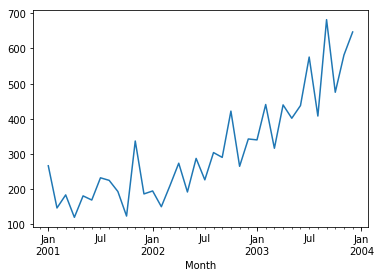

In [8]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('200'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, nrows=36, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

We see that the shampoo sales data has an upward trend. 

This suggests that the timeseries is not stationary and will require differencing to make it stationary. 

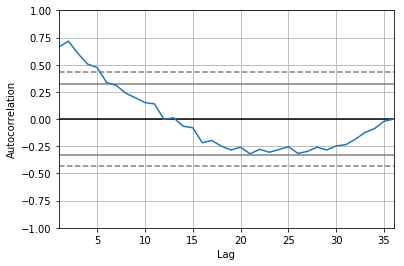

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

Running the autocorrelation shows us that there is a positive correlation for the first 10-12 lags, and approximately the first 5 are significant. 

We will choose 5 as the starting point for the AR parameter. 

## ARIMA with Python
The statsmodel library provides the the ability to fit an ARIMA model. 

An ARIMA model can be created using the statsmodel library by:

1. Define the model by calling ARIMA() and passing the p, d, and q parameters
2. The model is prepared on teh dtraining data calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   35
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                                                css-mle   S.D. of innovations             64.241
Date:                                         Mon, 05 Mar 2018   AIC                            406.340
Time:                                                 20:32:07   BIC                            417.227
Sample:                                             02-01-2001   HQIC                           410.098
                                                  - 12-01-2003                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

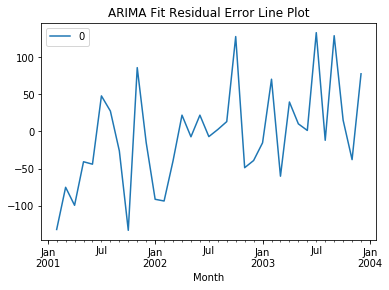

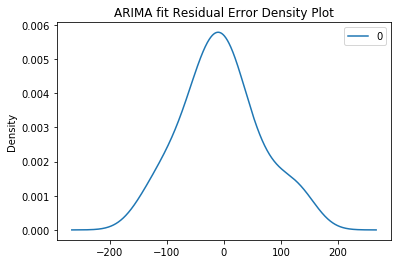

                0
count   35.000000
mean    -5.495238
std     68.132881
min   -133.296602
25%    -42.477952
50%     -7.186772
75%     24.748276
max    133.237924


In [12]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(dips=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.title('ARIMA Fit Residual Error Line Plot')
pyplot.show()
residuals.plot(kind='kde')
pyplot.title('ARIMA fit Residual Error Density Plot')
pyplot.show()
print(residuals.describe())

The line plot of residual errors shows there may still be some trend information not captured by the model

The density plot looks like a Gaussian distribution, but not centered on zero.

## Rolling Forecast ARIMA Model
We can use the predict() function on the ARIMAResults objet to make predictions. it accepts the index of the time steps to make predictions as arguments. 

We can also use the forecast() functin, which performs a one-step forecast using the model. 

A rolling forecast is required given teh dependence on observations in prior tie steps for differencing and the AR model. A crude way to perform this rolling forecase is to re-create the ARIMA model after each new observation is receieved. 

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=349.117744, expected=342.300000
predicted=306.513018, expected=339.700000
predicted=387.376406, expected=440.400000
predicted=348.154160, expected=315.900000
predicted=386.308770, expected=439.300000
predicted=356.082070, expected=401.300000
predicted=446.379499, expected=437.400000
predicted=394.737335, expected=575.500000
predicted=434.915545, expected=407.600000
predicted=507.923458, expected=682.000000
predicted=435.483044, expected=475.300000
predicted=652.743834, expected=581.300000
predicted=546.343533, expected=646.900000
Test MSE: 6958.322


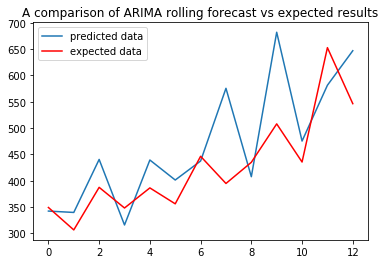

In [20]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test, label='predicted data')
pyplot.title('A comparison of ARIMA rolling forecast vs expected results')
pyplot.plot(predictions, color='red', label='expected data')
pyplot.legend()
pyplot.show()

## Configuring an ARIMA Model
the Box-Jenkins Methodology is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model. The steps are as follows:

1. Model Identification: Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required. 
2. Parameter Estimation: Use a fitting prodecure to find the coefficients of the regresion model. 
3. Model Checking: use plots and statistical test of the residual errors to determine the amount and type of temporal structure ot captured by the model. 

This process is repeated until either a desireable leel of fit is achieved on the in-sample or out-of-sample observations. 